In [71]:
import pandas as pd
import numpy as np

def load_acquisition_data(filelocation):
    format = '%Y-%m-%d %H:%M:%S,%f'
    df =pd.read_csv(filelocation, sep=';',parse_dates=True);
    times = pd.to_datetime(df.DateTime , format=format)
    df.set_index(times, inplace=True)
    df['ValveOpening'] = df['EntryLoad'] - df['EntryLoad'].shift(-1) <0
    df['FeatureMix'] = df['PumpCurrent'] / df['PumpVelocity'] 
    return df

pumpdata = load_acquisition_data('..\data\PumpMeasuresFormated.csv')
pumpdata["Flow"]=(pumpdata["Flow"]/97)*360
pumpdata["PumpCurrent"] = ((pumpdata["PumpCurrent"]/4095)*2.44 +3.85)/(11.8*0.5)
pumpdata["EntryLoad"]= pumpdata["EntryLoad"]/255*100

With the statsmodel library we will clean the noise contained in the current of the pump measured and we keep the trend. This process is already shown in the data visualisation and analysis.

Current Filtered represents the trend of the current obtained by the seasonal analysis <br>
The value measured of the current is obtained in labjack U3 via an analog to numeric converter with 12 bits precision <br>
An amplifier operational with a gain and an offset is used to convert the measure of the tension on the shunt to
a voltage varying form 0 to 2.44 volt <br>
The amplifier operational function transfert is a linear function with a gain of 11.8 and an offset of -3.85 <br>
The shunt resistor value is 0.5 ohm <br>
The formula here after transform the numeric value returned by the CAN to the intensity consumed by the pump <br> <br>
The flow meter provide 97 pulse for each litter <br>
The flow measure period is 10s <br>
The flow in l/h is obtained by (Nbpulse/97)*360


In [50]:
pumpdata.head()

,Id,Cycle,DateTime,Flow,EntryLoad,OutputLoad,PumpCurrent,PumpVelocity,ValveOpening,FeatureMix
DateTime,,,,,,,,,,
2017-04-23 14:38:39.310,0,1,"2017-04-23 14:38:39,310",360.00000,100.000000,100,1.029644,10,False,373.4
2017-04-23 14:38:52.515,1,1,"2017-04-23 14:38:52,515",352.57732,98.039216,100,1.049539,10,False,393.1
2017-04-23 14:39:05.554,2,1,"2017-04-23 14:39:05,554",356.28866,96.078431,100,1.094682,10,False,437.8
2017-04-23 14:39:18.585,3,1,"2017-04-23 14:39:18,585",363.71134,94.117647,100,1.024190,10,False,368.0
2017-04-23 14:39:31.616,4,1,"2017-04-23 14:39:31,616",363.71134,92.156863,100,1.096399,10,False,439.5


In [51]:
pumpdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2017-04-23 14:38:39.310000 to 2017-04-23 22:51:14.356000
Data columns (total 10 columns):
Id              1980 non-null int64
Cycle           1980 non-null int64
DateTime        1980 non-null object
Flow            1980 non-null float64
EntryLoad       1980 non-null float64
OutputLoad      1980 non-null int64
PumpCurrent     1980 non-null float64
PumpVelocity    1980 non-null int64
ValveOpening    1980 non-null bool
FeatureMix      1980 non-null float64
dtypes: bool(1), float64(4), int64(4), object(1)
memory usage: 156.6+ KB


In [52]:
pumpdata.describe()

,Id,Cycle,Flow,EntryLoad,OutputLoad,PumpCurrent,PumpVelocity,FeatureMix
count,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000
mean,989.500000,6.000000,212.835989,49.860566,77.272727,0.920341,7.727273,333.991580
std,571.721086,3.163077,80.971236,29.117532,24.902769,0.098030,1.601024,79.503857
min,0.000000,1.000000,0.000000,0.000000,50.000000,0.741213,5.000000,149.166667
25%,494.750000,3.000000,152.164948,24.901961,50.000000,0.842810,6.000000,278.900000
50%,989.500000,6.000000,233.814433,49.803922,100.000000,0.928047,8.000000,340.050000
75%,1484.250000,9.000000,267.216495,74.705882,100.000000,0.997983,9.000000,391.312500
max,1979.000000,11.000000,382.268041,100.000000,100.000000,1.101348,10.000000,542.875000


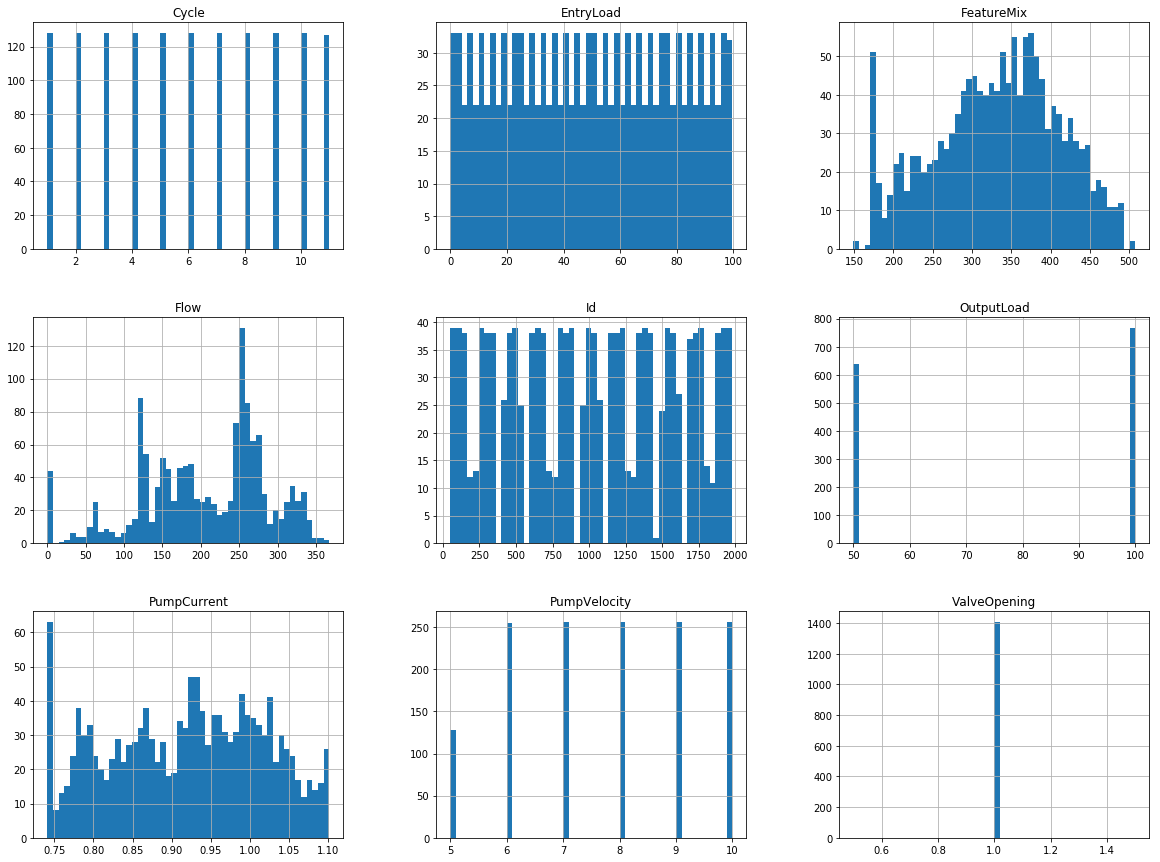

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
#pumpdata.hist(bins=50, figsize=(20,15))
#subset = pumpdata[pumpdata.Cycle==9]
subset = pumpdata[pumpdata.ValveOpening==True]
subset.hist(bins=50, figsize=(20,15))
plt.show()

In [74]:
corrMatrix = pumpdata.corr()
corrMatrix["Flow"].sort_values(ascending=False)

Flow            1.000000
PumpCurrent     0.528724
EntryLoad       0.469189
FeatureMix      0.459710
OutputLoad      0.426974
PumpVelocity    0.420789
ValveOpening   -0.135560
Id             -0.601973
Cycle          -0.616372
Name: Flow, dtype: float64

In [76]:
corrMatrix = pumpdata.corr()
corrMatrix["PumpCurrent"].sort_values(ascending=False)

PumpCurrent     1.000000
FeatureMix      0.891328
PumpVelocity    0.860930
Flow            0.528724
EntryLoad       0.105407
OutputLoad      0.086678
ValveOpening   -0.017460
Id             -0.512428
Cycle          -0.517659
Name: PumpCurrent, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000008842BE5668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000008841D900B8>]], dtype=object)

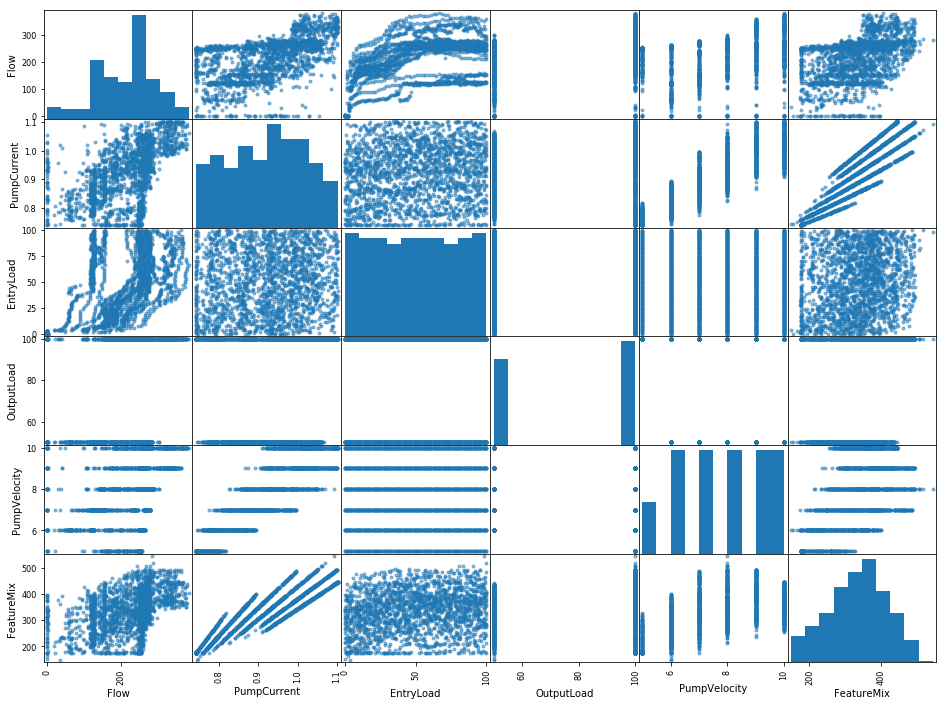

In [55]:
from pandas.tools.plotting import scatter_matrix
attributes = ["Flow","PumpCurrent","EntryLoad","OutputLoad","PumpVelocity","FeatureMix"]
scatter_matrix(pumpdata[attributes],figsize=(16,12))

C:\Anaconda343\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


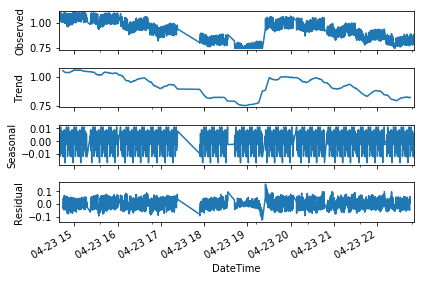

In [56]:
import statsmodels.api as sm 
decompfreq = 50
res = sm.tsa.seasonal_decompose(pumpdata.PumpCurrent.interpolate(),freq=decompfreq, model='additive')
resplot = res.plot()
type(res.trend)

pumpdata["CurrentFiltered"] = res.trend

In [57]:
corrMatrix = pumpdata.corr()
corrMatrix["Flow"].sort_values(ascending=False)

Flow               1.000000
PumpCurrent        0.528724
CurrentFiltered    0.524873
EntryLoad          0.469189
FeatureMix         0.459710
OutputLoad         0.426974
PumpVelocity       0.420789
ValveOpening      -0.135560
Id                -0.601973
Cycle             -0.616372
Name: Flow, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000088417E82E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000884479C5C0>]], dtype=object)

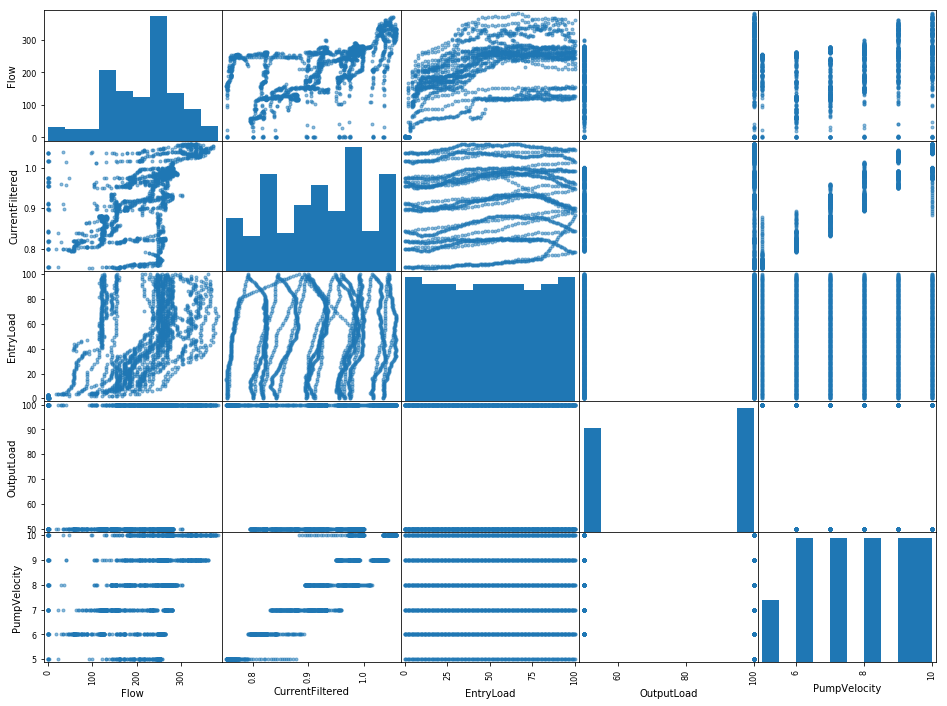

In [58]:
#attributes = ["Flow","PumpCurrent","CurrentFiltered","EntryLoad","OutputLoad","PumpVelocity","FeatureMix"]
attributes = ["Flow","CurrentFiltered","EntryLoad","OutputLoad","PumpVelocity"]
scatter_matrix(pumpdata[attributes],figsize=(16,12))

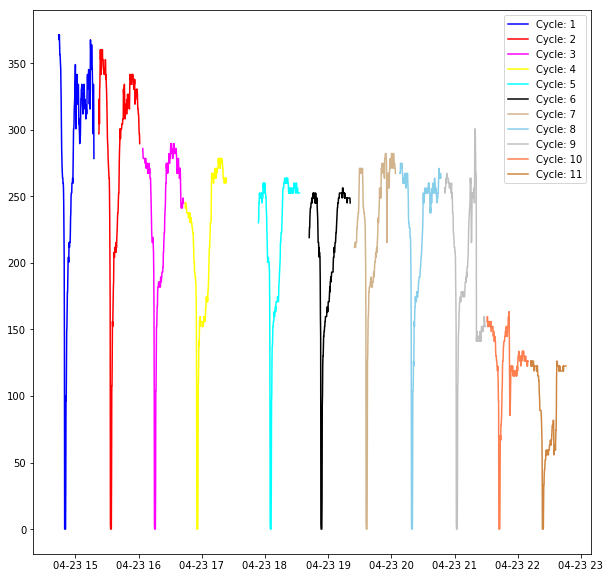

In [59]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    #subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.Flow,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

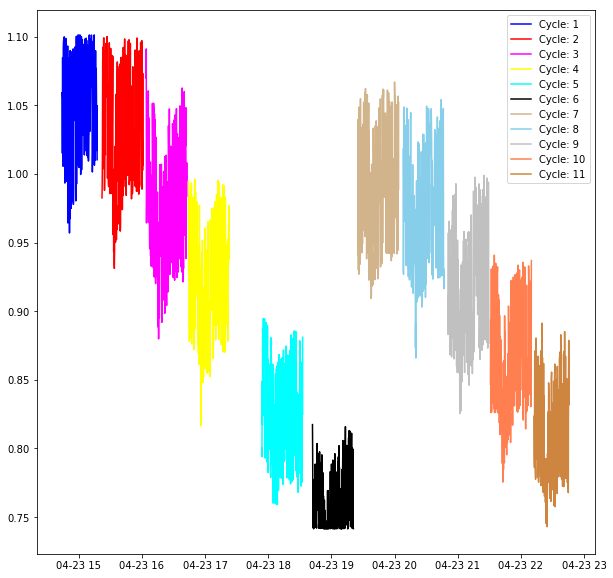

In [60]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    #subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.PumpCurrent,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

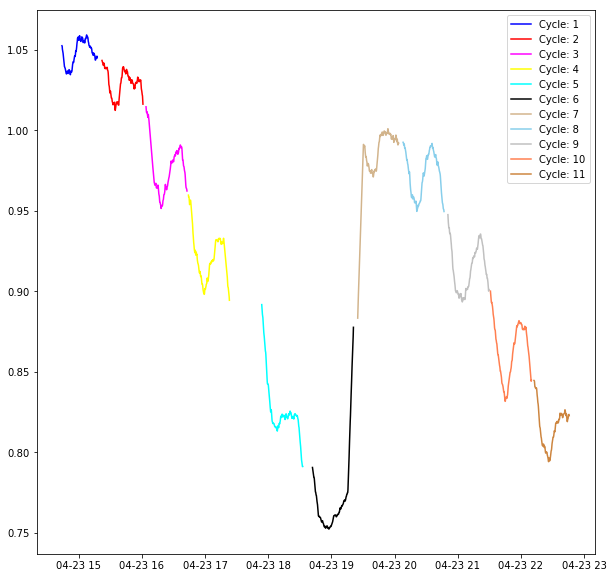

In [61]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    #subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.CurrentFiltered,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

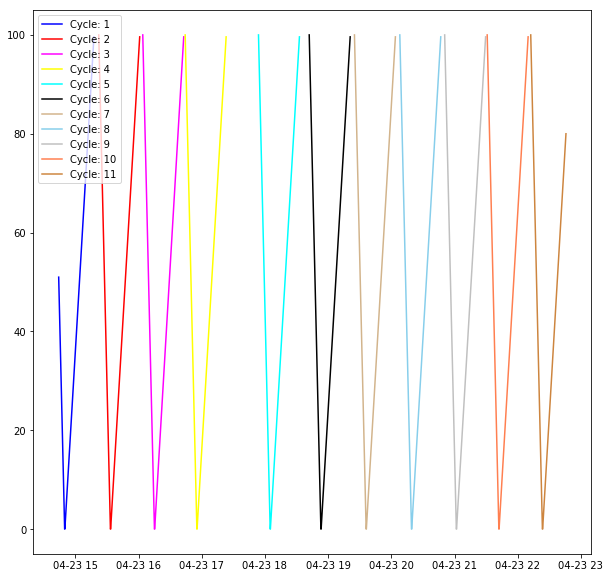

In [62]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    #subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.EntryLoad,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

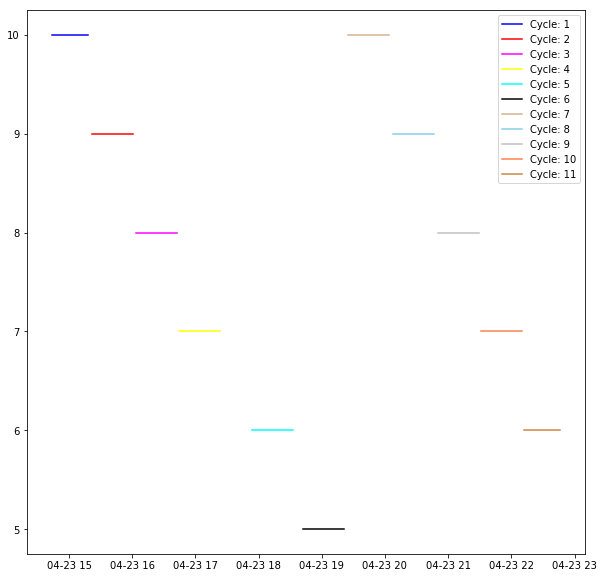

In [63]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    #subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.PumpVelocity,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

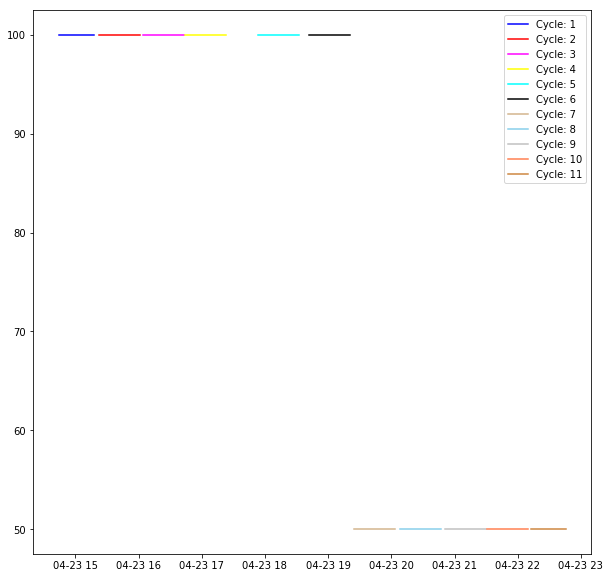

In [64]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    #subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.OutputLoad,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

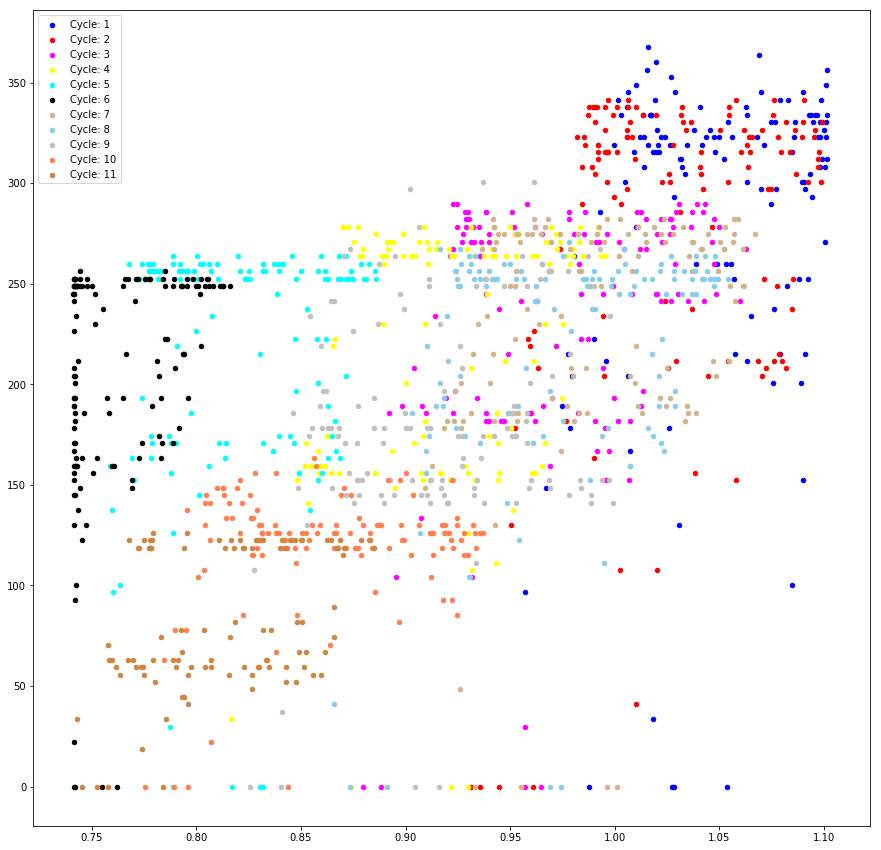

In [65]:
plt.figure(figsize=(15,15))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.scatter(subset.PumpCurrent, subset.Flow,s=20, c=colors[cycle-1], label=cyclename)
plt.legend()

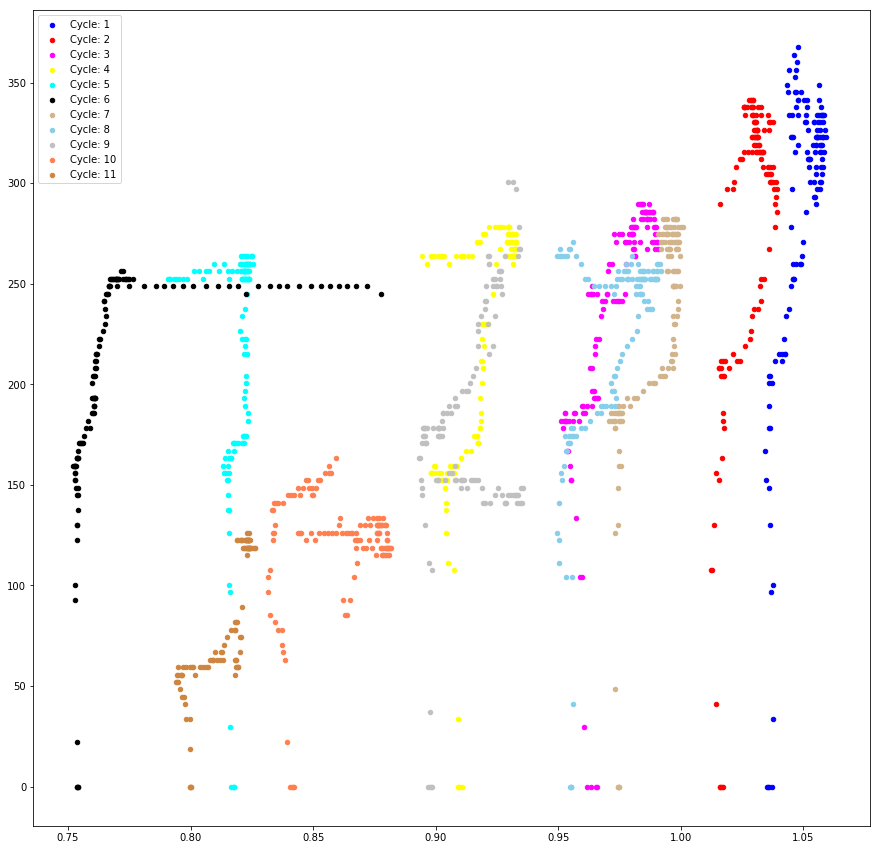

In [66]:
plt.figure(figsize=(15,15))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle) 
    cycleColor = cycle-1
    plt.scatter(subset.CurrentFiltered, subset.Flow,s=20, c=colors[cycleColor], label=cyclename)
plt.legend()

### This graph represents the variation of the flow in founction of the entry for the 6 first cycles

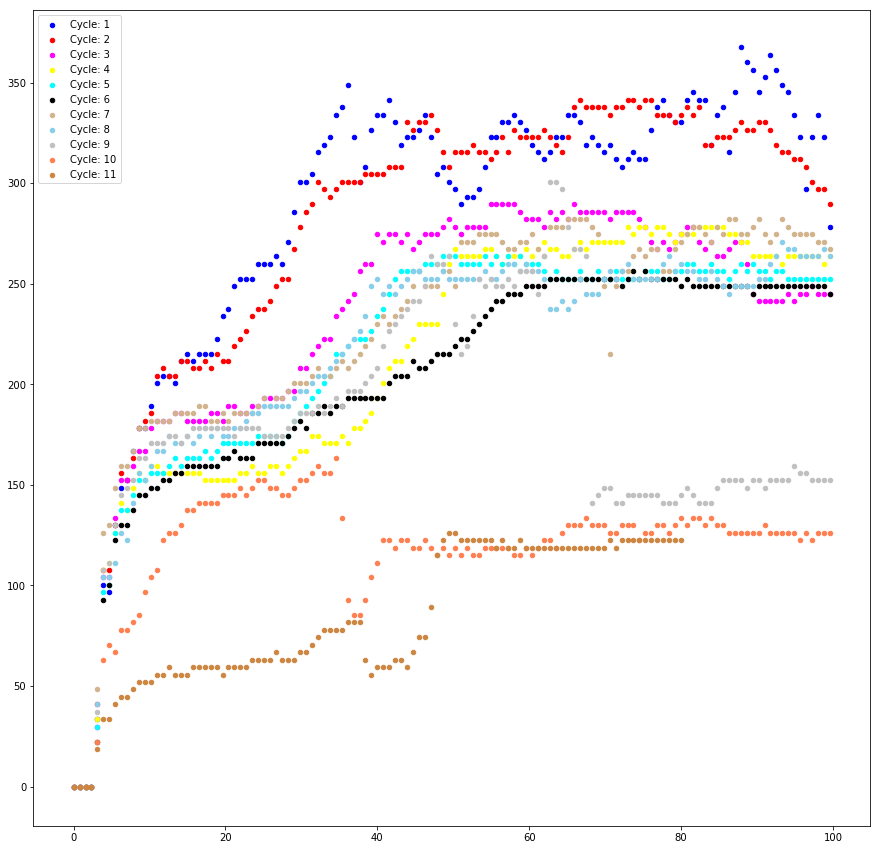

In [67]:
plt.figure(figsize=(15,15))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.scatter(subset.EntryLoad, subset.Flow, s=20, c=colors[cycle-1], label=cyclename)
plt.legend()

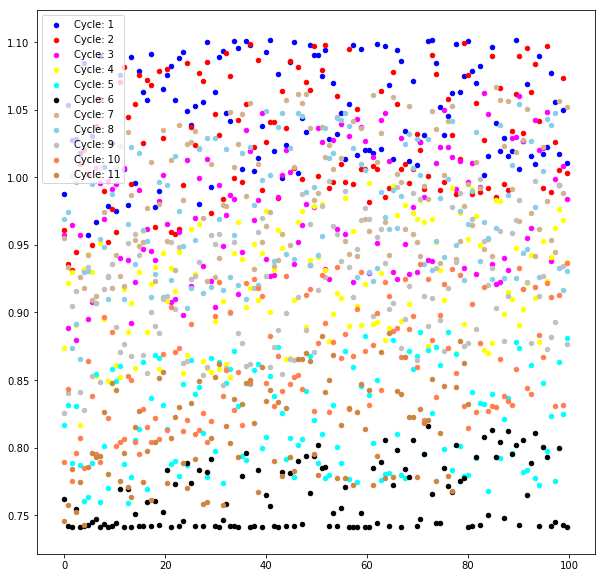

In [68]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.scatter(subset.EntryLoad, subset.PumpCurrent, s=20, c=colors[cycle-1], label=cyclename)
plt.legend()

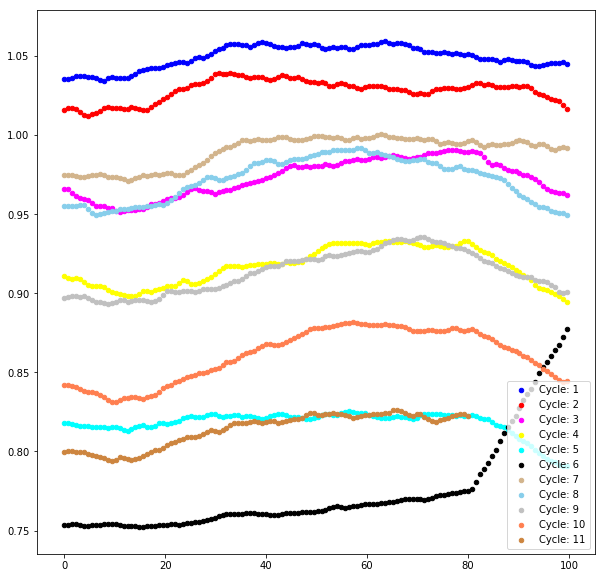

In [69]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.scatter(subset.EntryLoad, subset.CurrentFiltered, s=20, c=colors[cycle-1], label=cyclename)
plt.legend()

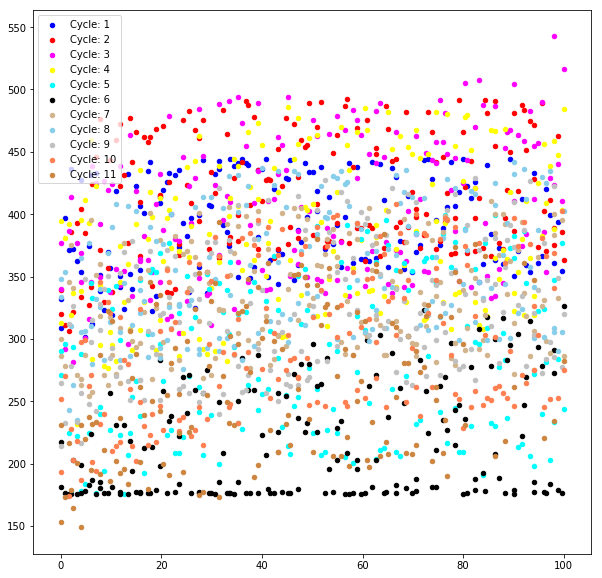

In [70]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    #subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.scatter(subset.EntryLoad, subset.FeatureMix, s=20, c=colors[cycle-1], label=cyclename)
plt.legend()